### Imports

In [1]:
import numpy as np
from tqdm import tqdm
from scipy.stats import laplace, norm, poisson, uniform
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt

###### • Распределение для заданий 1 и 2: распределение Лапласа с параметром сдвига равным 2 и параметром масштаба равным 5.
###### • Функция интенсивности для третьего задания: λ(t) = exp(t−1), t ∈ [0, 1].

### 1 task
Пусть ξ1, ξ2, . . . — последовательность независимых случайных величин из заданного распределения. Привести графическую иллюстрацию закона больших чисел.
Hint: можно, например, построить график выборочного среднего Sn/n в зависимости от n и посмотреть, как он ведёт себя при увеличении n.

In [24]:
class LaplaceDistributionLLN:
    """
    Работа с ЗБЧ для Лапласовского распределения
    """

    def __init__(self, mu, b):
        self.mu = mu
        self.b = b

    def generate_sample(self, n):
        return laplace.rvs(size=n, loc=self.mu, scale=self.b)

    def sample_expectancy(self, sample):
        return np.mean(sample)

    @property
    def expectancy(self):
        return self.mu

    @staticmethod
    def LLN_iteration(prev_Sn_over_n, cur, n):
        """
        Sn/n
        -----
        prev_Sn_over_n = Sn-1/(n-1)
        cur = Xn
        => Sn/n = [(Sn-1/(n-1)) * (n-1) + Xn] / n
        """
        return (prev_Sn_over_n * (n - 1) + cur) / n

    def LLN(self, N):
        """
        ЗБЧ
        """
        Sn_over_n = [0]
        for n in range(1, N):
            random_var_n = self.generate_sample(1).item()  # генерация n-ой случайной величины
            Sn_over_n.append(self.LLN_iteration(Sn_over_n[n - 1], random_var_n, n))
        return Sn_over_n

    def plot_LNN(self, N):
        """
        График ЗБЧ для одной реализации
        """
        Sn_over_n = self.LLN(N)
        plt.plot(range(N), Sn_over_n, label="Sn/n")
        plt.axhline(self.expectancy, linestyle='--', color='orange', label="EX")
        plt.xlabel("n")
        plt.ylabel("value")
        plt.legend()
        plt.title("ЗБЧ для одной реализации")
        plt.show()

    def avg_LLN(self, M, N):
        """
        ЗБЧ усредненое между реализациями
            M: нужное число реализаций
            N: максимальное N для ЗБЧ
        """
        llns = []
        for _ in tqdm(range(M), f"Samples generated: ", unit='samples'):
            llns.append(self.LLN(N))

        mean_llns = np.mean(llns, axis=0)
        return mean_llns

    def plot_avg_LLN(self, M, N):
        """
        График ЗБЧ усредненого между M реализациями
        """
        avg_Sn_over_n = self.avg_LLN(M, N)
        plt.plot(range(N), avg_Sn_over_n, label="avg. Sn/n")
        plt.axhline(self.expectancy, linestyle='--', color='orange', label="EX")
        plt.xlabel("n")
        plt.ylabel("value")
        plt.legend()
        plt.title(f"ЗБЧ для {M} реализаций с.в.")
        plt.show()


    def approximate_with_sqrt(self, avg_Sn_over_n):
        """
        Находит c, которое соответствует лучше аппроксимации c/sqrt(n) для |avg[Sn/n] - EX|
        """
        best_C = 0
        min_error = float('inf')

        N = len(avg_Sn_over_n)
        l1_points = np.abs(avg_Sn_over_n - self.expectancy)
        for C in np.arange(0, 3, 0.01):
            approximation_points = [C/np.sqrt(n) if n != 0 else 0 for n in range(N)]
            l1_error = np.sum(np.abs(l1_points - approximation_points))
            if l1_error < min_error:
                min_error = l1_error
                best_C = C
        return best_C

    def plot_sqrt_approximation_of_avg_LLN(self, avg_LLN):
        """
        График того, как c/sqrt(n) аппроксимирует |avg[Sn/n] - EX|
        """
        N = len(avg_LLN)
        best_C = laplace_distribution.approximate_with_sqrt(avg_LLN)
        ns = np.linspace(0.0001, N, N*100)
        plt.plot(range(N), np.abs(avg_LLN - self.expectancy), label="| avg[Sn/n] - EX |")
        plt.plot(ns, best_C/np.sqrt(ns), label=f"c/sqrt(n)\nc={best_C:0.2f}", linestyle='--')
        plt.legend()
        plt.title("c/sqrt(n) ~ abs(Sn/n - EX)")
        plt.ylim((-0.1, 0.3))
        plt.xlim(left=-N/50, right=N/4)
        plt.show()


In [25]:
laplace_distribution = LaplaceDistributionLLN(2.0, 5.0)
print(f"Ожидание распределения Лапласа = {laplace_distribution.expectancy}")

Ожидание распределения Лапласа = 2.0


##### Далее М - кол-во реализаций. N - размер выборки.

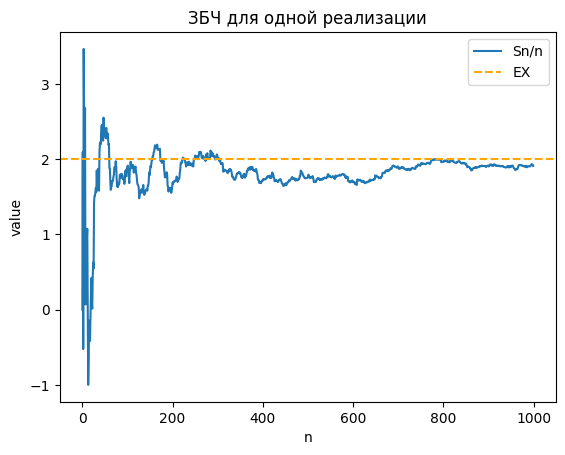

In [14]:
laplace_distribution.plot_LNN(N=1000)

Samples generated: 100%|██████████| 500/500 [00:19<00:00, 25.79samples/s]


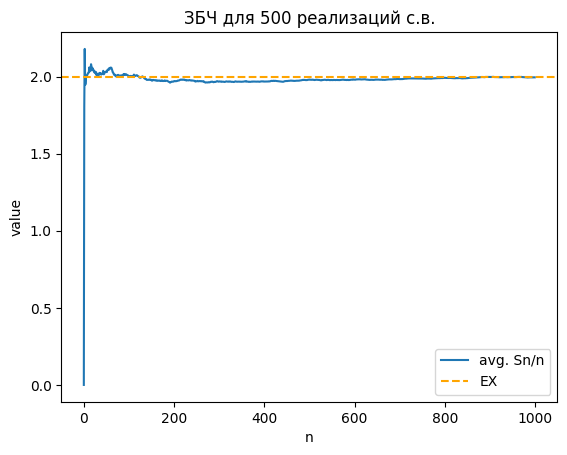

In [15]:
laplace_distribution.plot_avg_LLN(M=500, N=1000)

Samples generated: 100%|██████████| 500/500 [02:50<00:00,  2.94samples/s]


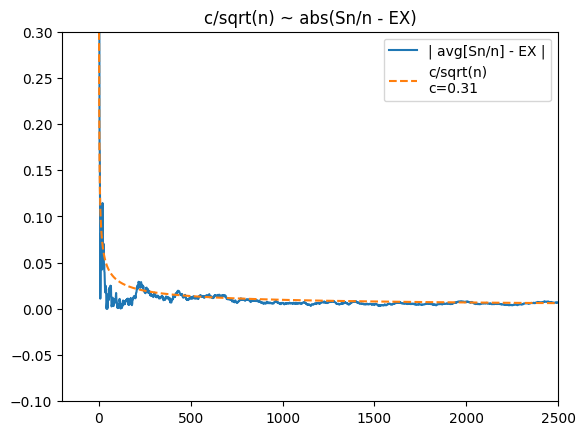

In [26]:
avg_LLN = laplace_distribution.avg_LLN(M=500, N=10000)
laplace_distribution.plot_sqrt_approximation_of_avg_LLN(avg_LLN)

### Task 2
Пусть ξ1, ξ2, . . . — последовательность независимых случайных величин из заданного распределения. Привести графическую иллюстрацию центральной предельной теоремы.
Hint: можно, например, эмпирически оценить распределение случайной величины $\frac{S_n - nEξ1}{\sqrt{nDξ1}}$ при разных n (= 5, 10, 20, 40, 80, . . .) и сравнить его со стандартным нормальным. Также, нужно придумать, как посчитать «расстояние» между этими двумя распределениями.

In [131]:
class LaplaceDistributionCLT:
    """
    Работа с ЦПТ для Лапласовского распределения
    """

    def __init__(self, mu, b):
        self.mu = mu
        self.b = b


    def generate_sample(self, n):
        return laplace.rvs(size=n, loc=self.mu, scale=self.b)

    def sample_expectancy(self, sample):
        return np.mean(sample)

    @property
    def expectancy(self):
        return self.mu

    @property
    def variance(self):
        return 2*self.b**2

    def CLT(self, N):
        """
        ЦПТ
        (Sn - n*EX) / sqrt(n*DX) => eta ~ N(0,1)
        """
        sample = self.generate_sample(N)
        X_N = (np.sum(sample) - N * self.expectancy) / np.sqrt(N * self.variance)
        return X_N

    def sample_of_CLT(self, M, N, return_mean=False):
        """
        Возвращает M реализаций случайной величины (Sn - n*EX) / sqrt(n*DX)
        """
        return np.array([self.CLT(N) for _ in range(M)]) if not return_mean else np.mean(np.array([self.CLT(N) for _ in range(M)]), axis=0)


    def plot_CLT_hist(self, M, N):
        """
        Гистограмма по M реализациям с.в. (X1+...+Xn - nEX) / sqrt(n*DX)
        """
        CLT_sample = self.sample_of_CLT(M=M, N=N)
        x = np.linspace(min(CLT_sample), max(CLT_sample), num=100000)
        plt.hist(CLT_sample, density=True, bins=int(len(CLT_sample) ** (1 / 2.5)), alpha=0.5, label='CLT hist')
        plt.plot(x, norm.pdf(x), 'r', label="Standard Gaussian")
        plt.legend()
        plt.xlabel("x")
        plt.ylabel("density")
        plt.show()

    @staticmethod
    def error(ecdf_x, ecdf_y, target_distribution=norm):
        target_points = target_distribution.cdf(ecdf_x)
        N = len(target_points)
        error_supremum = 0
        for i in range(N):
            if i == 0:
                error_supremum = abs(target_points[i] - ecdf_y[i])
            else:
                error_supremum = max(abs(target_points[i] - ecdf_y[i]), abs(target_points[i] - ecdf_y[i - 1]), error_supremum)
        return error_supremum


    def kovmogorov_smirnov_distance(self, sample=None, ecdf=None, target_distribution=norm):
        """
        Ошибка вычисляется как sup(max[F*(x_i) - F(x_i), F*(x_{i-1}) -  F(x_i)])
        ~ Наибольшее абсолютное отклонение эмпирической функции от реальной в точках где она (F*) совершает "скачок"
        """
        if sample is not None:
            ecdf = ECDF(sample)
            return self.error(ecdf.x, ecdf.y, target_distribution)
        ecdf_X, ecdf_Y = ecdf
        return self.error(ecdf_X, ecdf_Y, target_distribution)

    def plot_CLT_cdf(self, M, N):
        CLT_sample = self.sample_of_CLT(M=M, N=N)
        ecdf = ECDF(CLT_sample)
        x = np.linspace(min(CLT_sample), max(CLT_sample), num=100000)

        plt.plot(x, norm.cdf(x, loc=0, scale=1), color="r", linestyle="--", label="Standard Gaussian CDF")
        plt.step(ecdf.x, ecdf.y, label="Empirical CLT-sample CDF")
        print(f"Kolmogorov distance = {self.kovmogorov_smirnov_distance(ecdf=(ecdf.x, ecdf.y))}")

        plt.xlabel('x')
        plt.ylabel('CDF')
        plt.legend()
        plt.show()

    def plot_pair(self, N):
        CLT_sample = self.sample_of_CLT(M=N, N=N)
        x = np.linspace(min(CLT_sample), max(CLT_sample), num=100000)
        ecdf = ECDF(CLT_sample)
        print(f"Kolmogorov distance for N={N}: {self.kovmogorov_smirnov_distance(ecdf=(ecdf.x, ecdf.y))}")

        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

        axes[0].step(ecdf.x, ecdf.y, label="Empirical CLT-sample CDF")
        axes[0].plot(x, norm.cdf(x, loc=0, scale=1), color="r", linestyle="--", label="Standard Gaussian CDF")
        axes[0].set_xlabel('x')
        axes[0].set_ylabel('CDF')
        axes[0].legend()

        bins = int(len(CLT_sample) ** (1 / 2.5)) if n >= 500 else int(len(CLT_sample) ** (1 / 2))
        axes[1].hist(CLT_sample, density=True, bins=bins, alpha=0.5, label='CLT hist')
        axes[1].plot(x, norm.pdf(x), 'r', label="Standard Gaussian")
        axes[1].legend()
        axes[1].set_xlabel("x")
        axes[1].set_ylabel("density")

        fig.tight_layout()
        plt.show()


In [132]:
laplace_CLT = LaplaceDistributionCLT(mu=2, b=5)


Kolmogorov distance for N=10: 0.3539646057237625


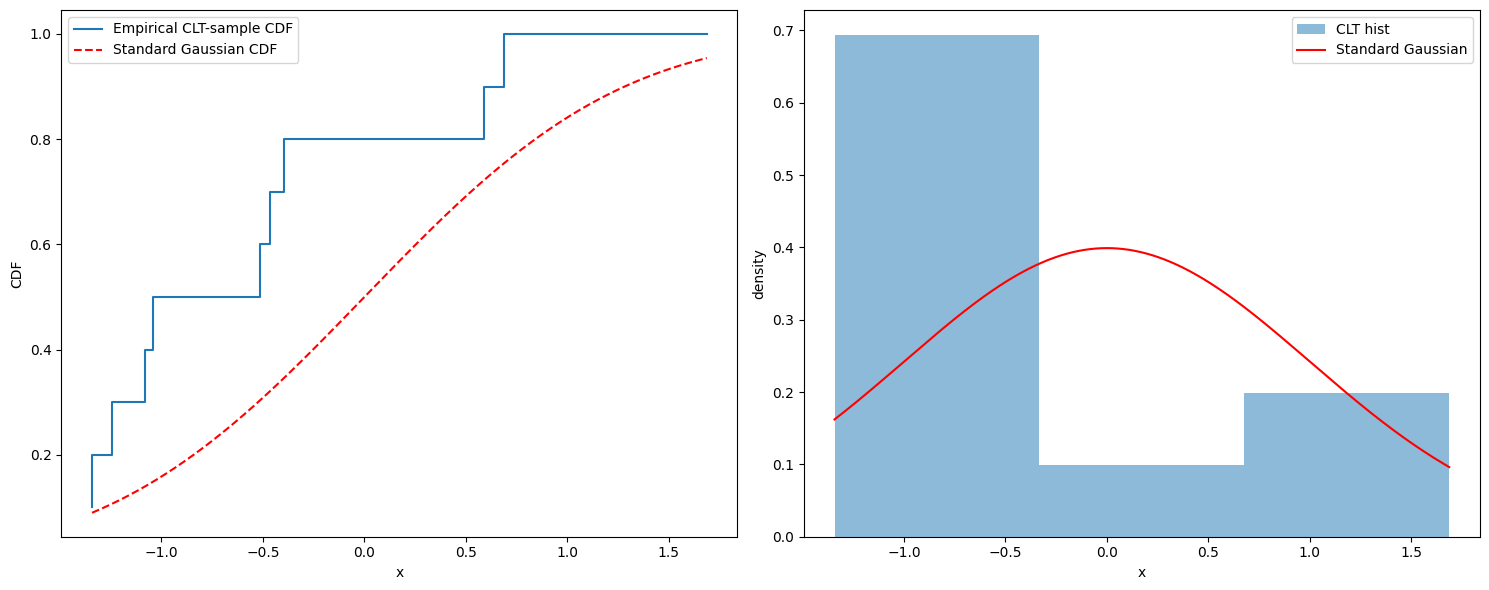

Kolmogorov distance for N=100: 0.0767556700791246


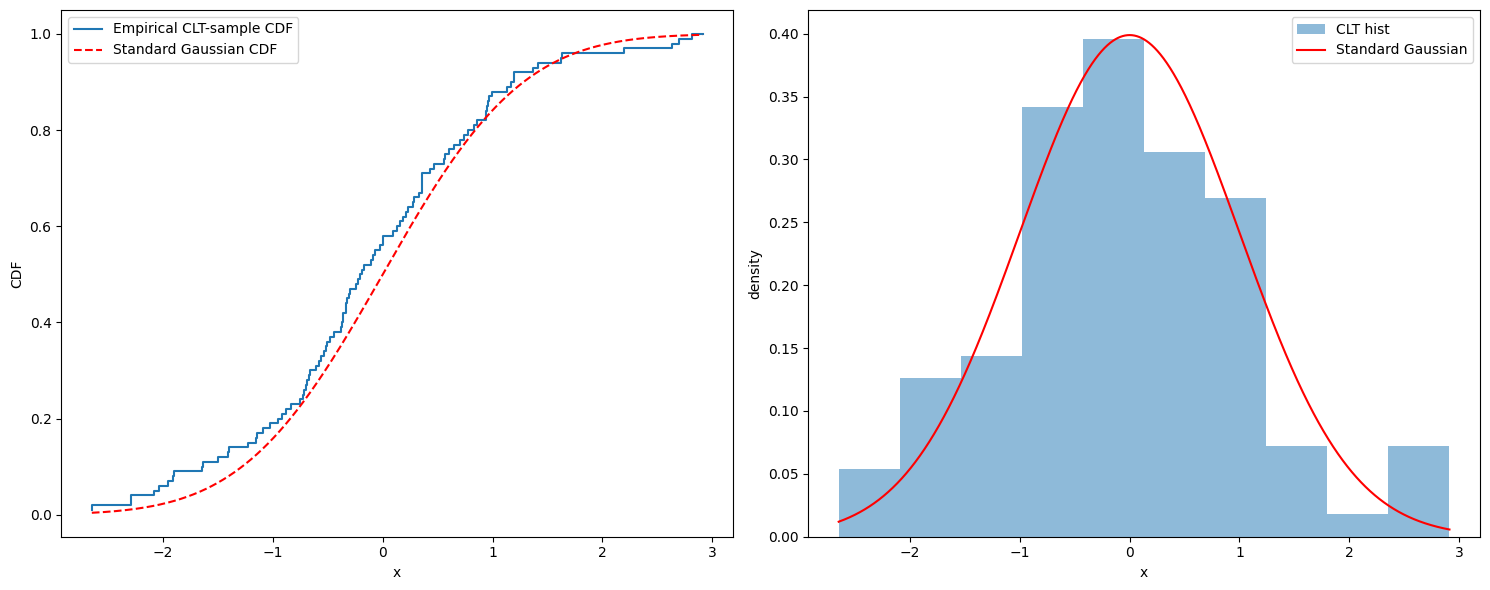

Kolmogorov distance for N=1000: 0.01727819846639078


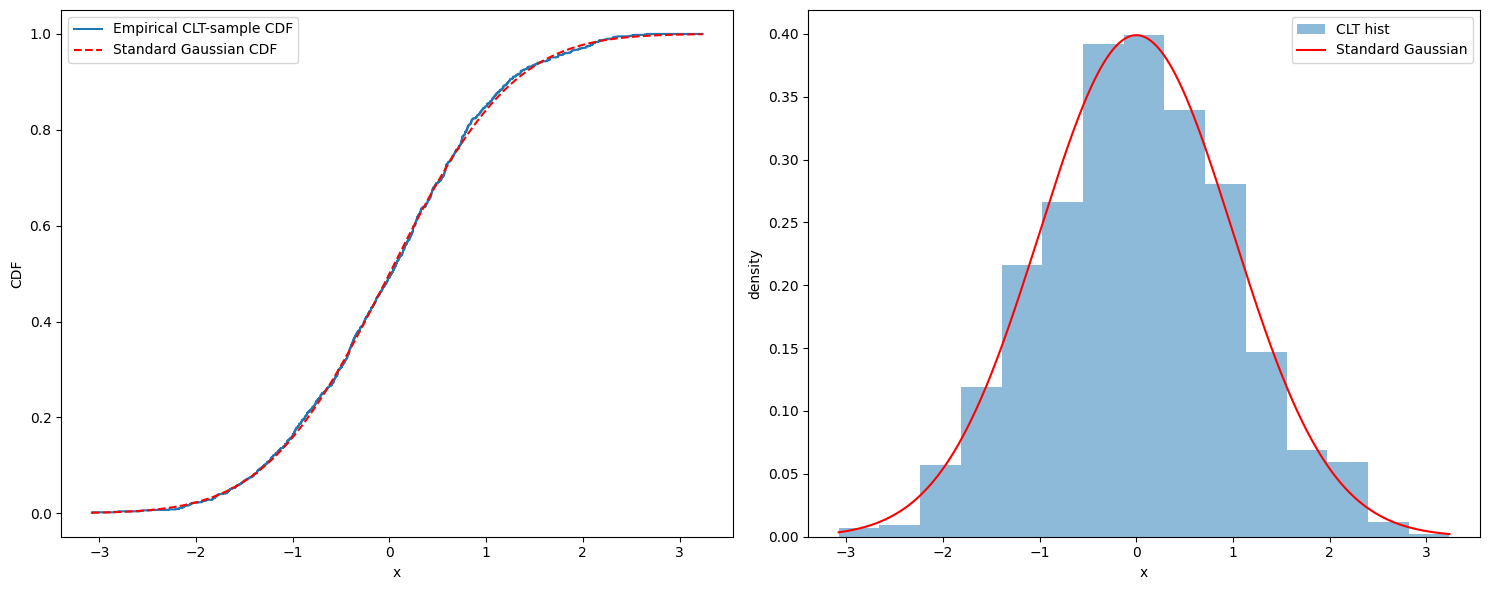

Kolmogorov distance for N=10000: 0.006186333630664231


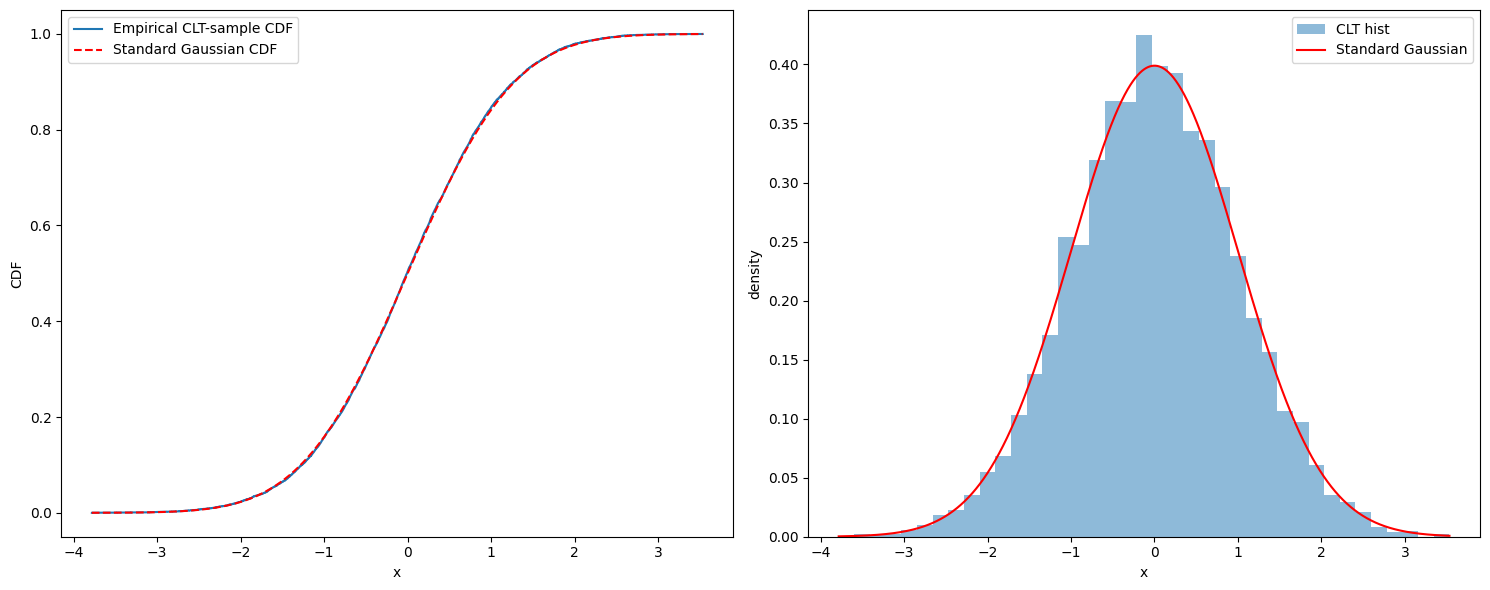

Kolmogorov distance for N=100000: 0.0022322383815386315


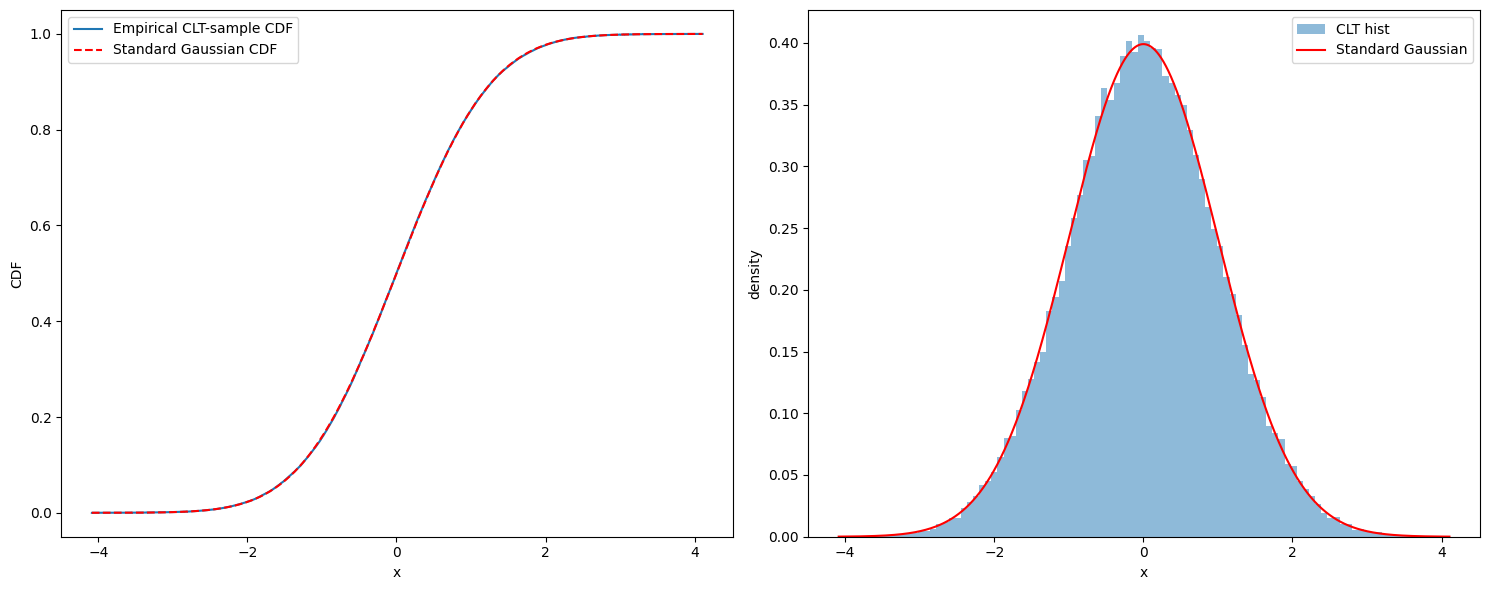

In [133]:
for n in [10, 100, 1000, 10000, 100000]:
    laplace_CLT.plot_pair(n)

### Task 3
Написать генератор неоднородного процесса Пуассона N(t) с заданной интенсивностью λ(t) на интервале времени [0, T]. Ожидаемый результат – график траектории процесса N(t).
Провести серию из n (= 10, 100, 1000, 10000, . . .) симуляций, по ним эмпирически оценить интенсивность и сравнить её с заданной функцией интенсивности.

In [134]:
T = 3  # так интереснее, чем T = 1 как в задании
lambda_func = lambda t: np.exp(t - 1)  # моя λ(t)

In [135]:
class InhomogeneousPP:
    """
    Работа с неоднородным Пуассоновским процессом
    """

    def __init__(self, T):
        self.T = T
        self.lambda_func = lambda_func
        self.integral_of_lambda_func = np.exp(T - 1) - np.exp(-1)  # посчитал аналитически
        self.F = lambda t: self.lambda_func(t) / self.integral_of_lambda_func  # нормировка: теперь F(T) - F(0) = 1
        self.F_inverse = lambda y: np.log(y) + np.log((np.exp(T) - 1) / np.exp(1)) + 1  # посчитал аналитически


    def generate_poisson_sample(self):
        N = poisson.rvs(mu=self.integral_of_lambda_func, size=1).item()
        etas = uniform.rvs(size=N)
        etas += self.F(0)  # чтобы затем получить значения из множества значений F - от F(0) до F(T)
        return np.array(sorted(self.F_inverse(etas)))


    def generate_n_poisson_samples(self, n):
        """
        N симуляций неоднородного ПП с заданной интенсивностью
        """
        samples = []
        for _ in range(n):
            samples.extend(self.generate_poisson_sample())
        return np.array(sorted(samples))

    def best_coeff(self, intervals, heights):
        best_C = 0
        min_error = float('inf')
        for C in range(-1000, 1000, 1):
            real_points = [C*self.lambda_func(t) for t in intervals]
            l1_error = np.sum(np.abs(heights - np.array(real_points)))
            if l1_error < min_error:
                min_error = l1_error
                best_C = C
        return best_C

    def plot_simulation(self):
        sample = self.generate_poisson_sample()
        X = np.linspace(0, self.T, 1000)
        plt.plot(X, self.lambda_func(X), color='r', label=f"λ(t)")
        plt.scatter(sample, self.lambda_func(sample), label="Simulated points")
        plt.legend()
        plt.xlabel("t")
        plt.ylabel("intensity")
        plt.title(f"Пример симуляции")
        plt.show()


    def plot_intensity(self):
        X = np.linspace(0, self.T, 10000)
        plt.plot(X, self.lambda_func(X), color="r", label="λ(t)")
        plt.xlabel("t")
        plt.ylabel("intensity")
        plt.title("Интенсивность  ПП")
        plt.legend()
        plt.show()

    def get_intervals_heights_from_sample(self, sample):
        intervals = []
        heights = []
        dt = 0.01 if len(sample) > 500 else 0.2
        dts = np.arange(0, T, dt)
        for i in dts:
            intervals.append(i)
            c = 0
            for point in sample:
                if i < point <= i + dt:
                    c += 1
            heights.append(c)
        return intervals, heights

    def plot_approximation(self, sample, n):

        X = np.linspace(0, self.T, 1000)
        intervals, heights = self.get_intervals_heights_from_sample(sample)
        best_C = self.best_coeff(intervals, heights)

        plt.step(intervals, heights, label="Эмпирическая оценка симуляции")
        plt.plot(X, best_C * self.lambda_func(X), linestyle="--", color='r', label=f"C * λ(t), где C={best_C}")
        plt.legend()
        plt.title(f"Эмпирическая оценка {n} симуляций ~ O(λ(t))")
        plt.xlabel("t")
        plt.show()


In [136]:
pp = InhomogeneousPP(T = T)

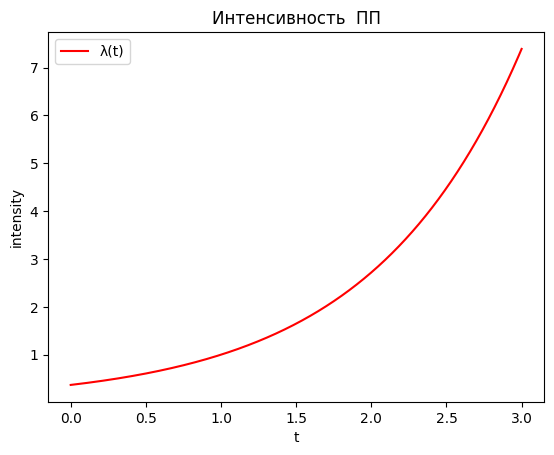

In [137]:
pp.plot_intensity()

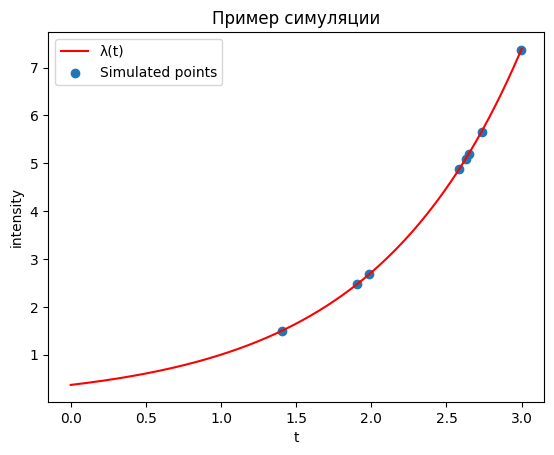

In [138]:
pp.plot_simulation()

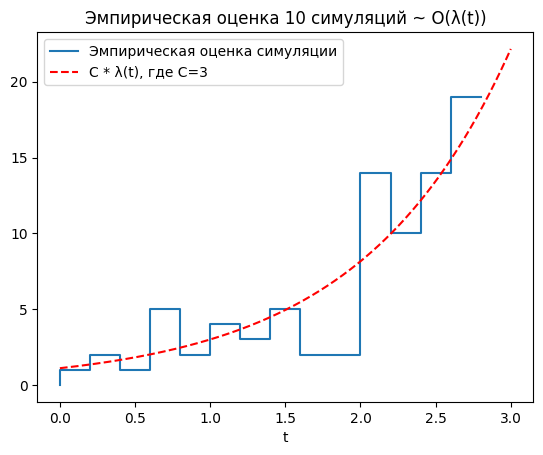

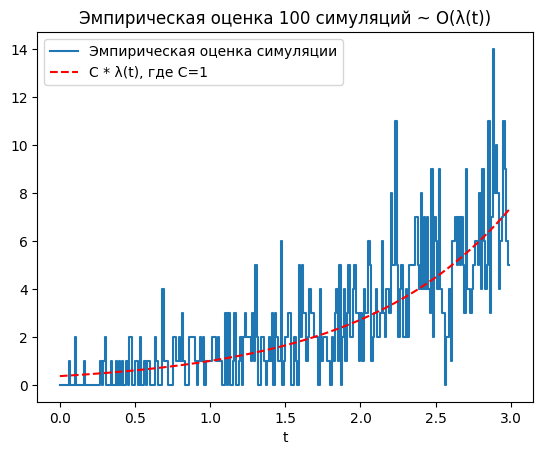

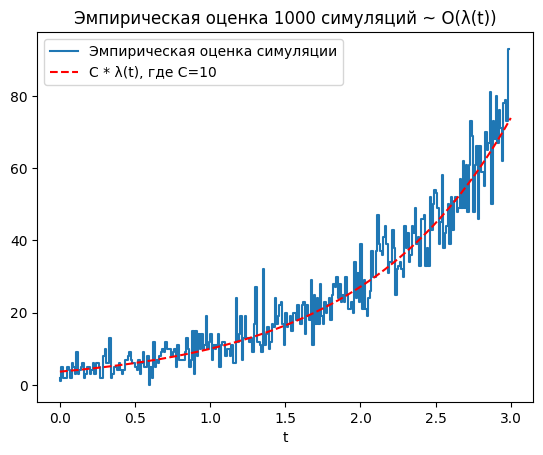

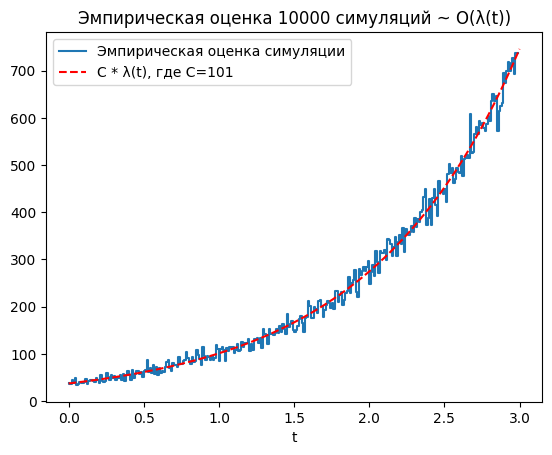

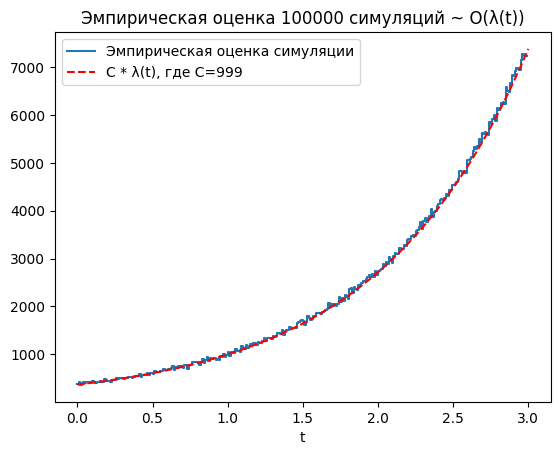

In [139]:
for n in [10, 100, 1000, 10000, 100000]:
    samples = pp.generate_n_poisson_samples(n)
    pp.plot_approximation(samples, n)